<a href="https://colab.research.google.com/github/monheritier/Tech-Test-ML-Coin/blob/main/Coin_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COIN SEGMENTATION

**1. Region Growing and Watershed Segmentation**

Image segmentation is a crucial step in computer vision and image analysis. It is used for various applications such as object recognition, image understanding and medical image analysis. Region growing is motivated by the idea that pixels belonging to the same object or region tend to have similar characteristics, such as intensity or colour.
The code loads a grayscale image and performs some preprocessing steps:
* Conversion to 8-bit format
* Gaussian smoothing for denoising.
* Adaptive thresholding to create a binary image.
* Morphological operations (closing and erosion) for further processing.
The distance transform is calculated on the binary image obtained after morphological operations. It represents the distance of each pixel to the nearest boundary.

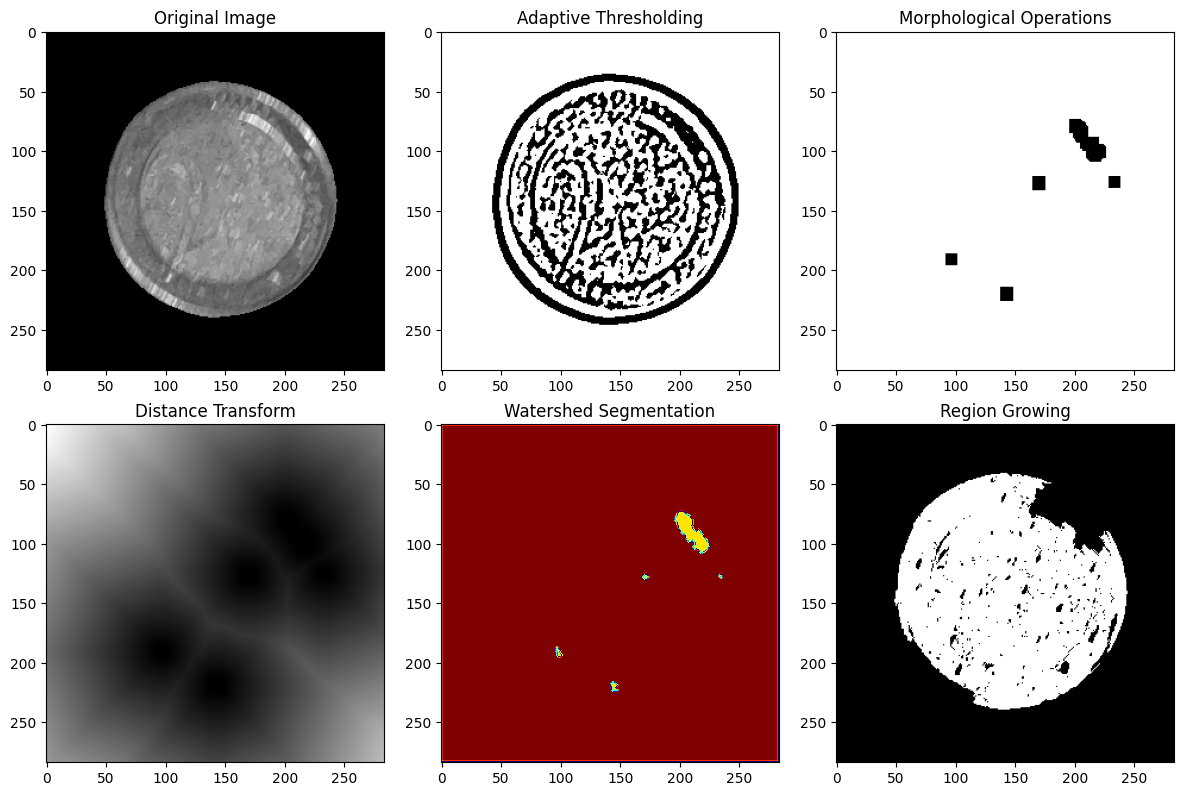

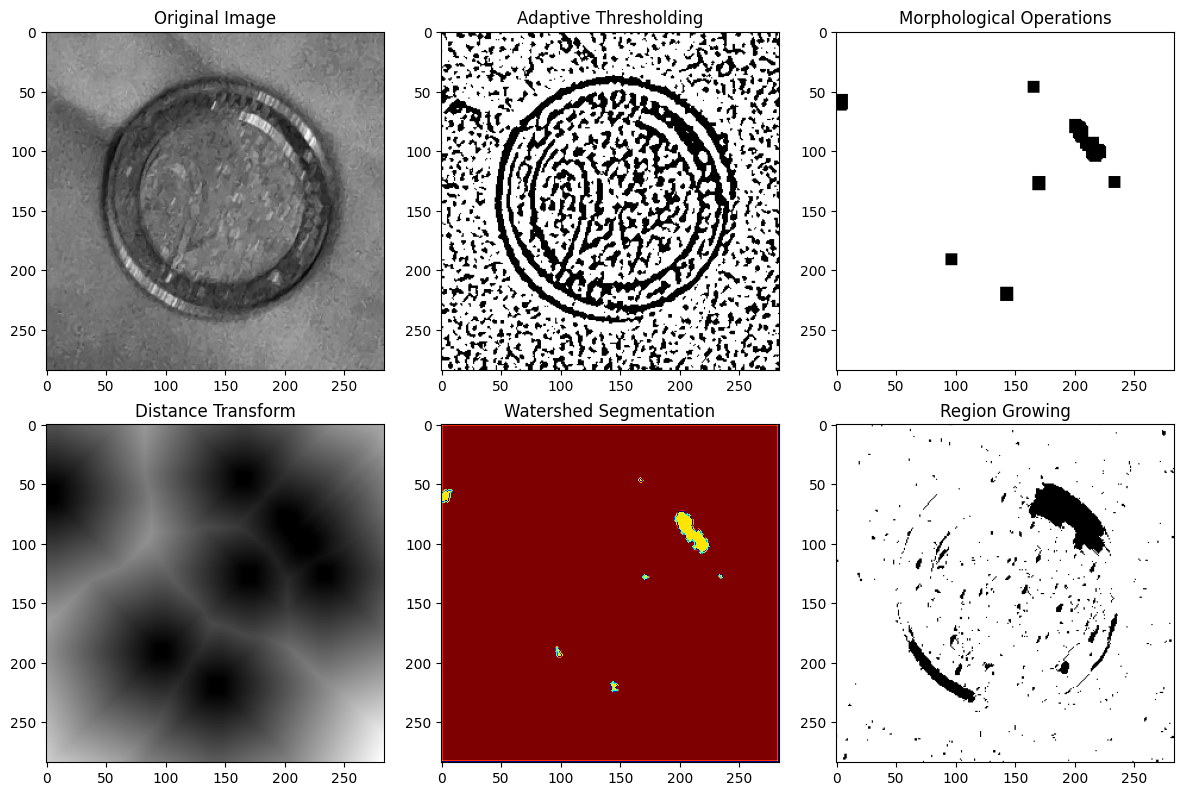

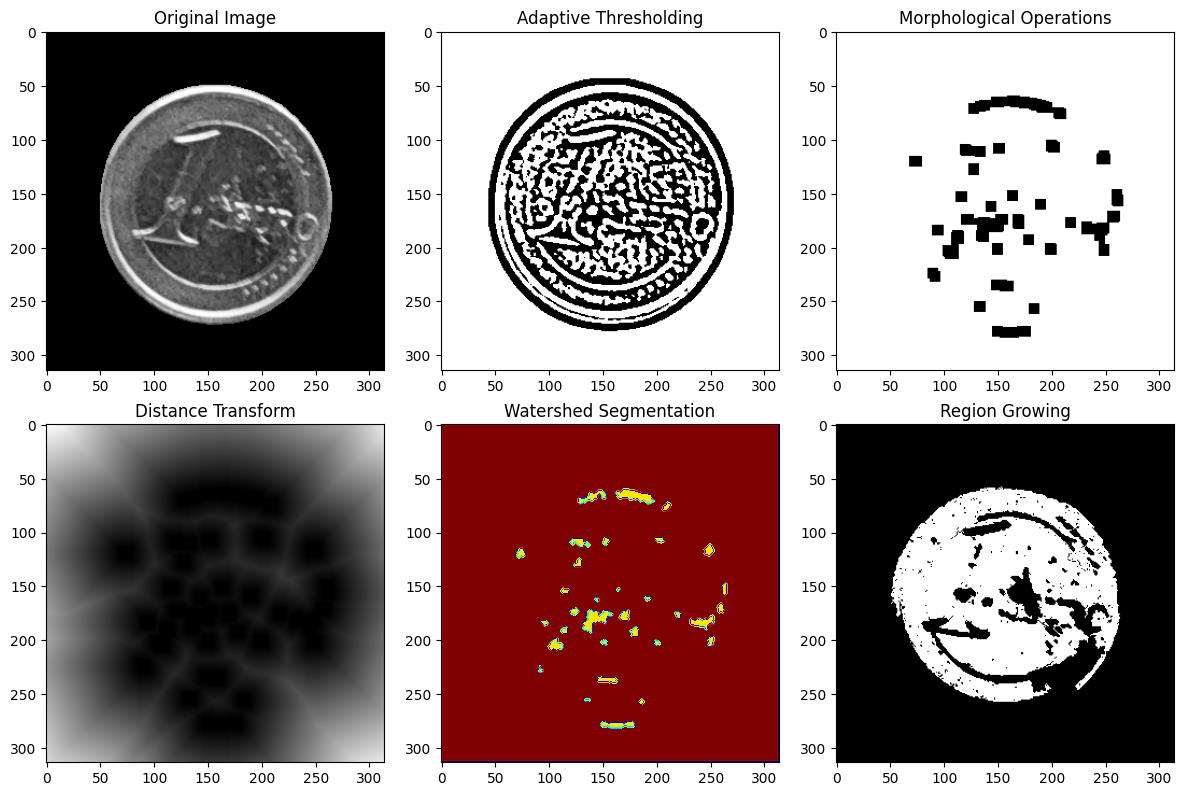

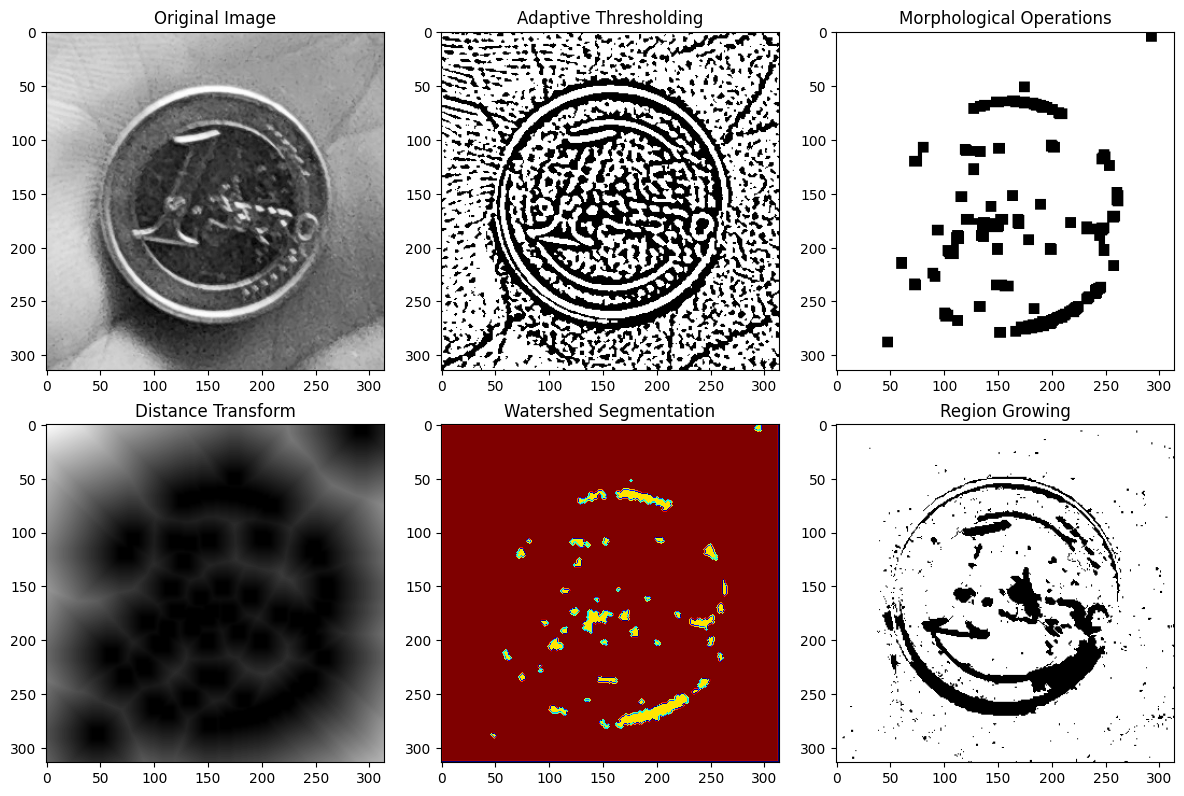

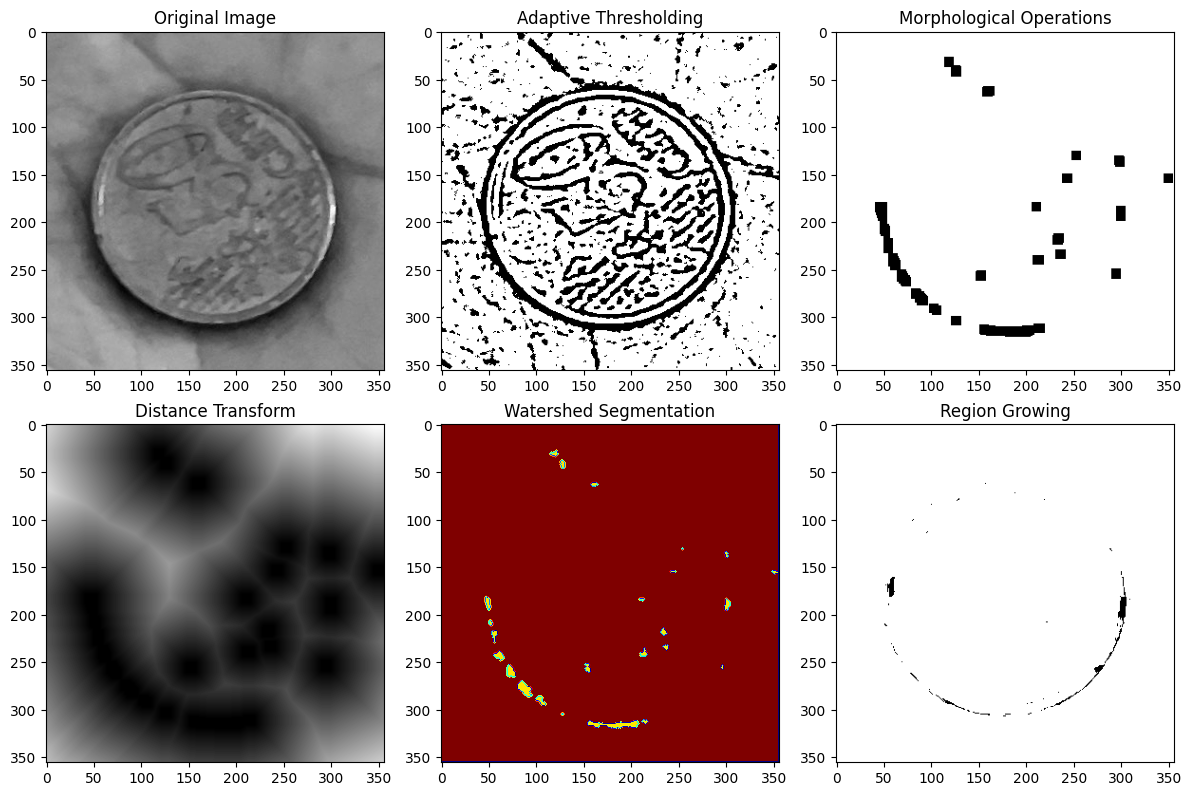

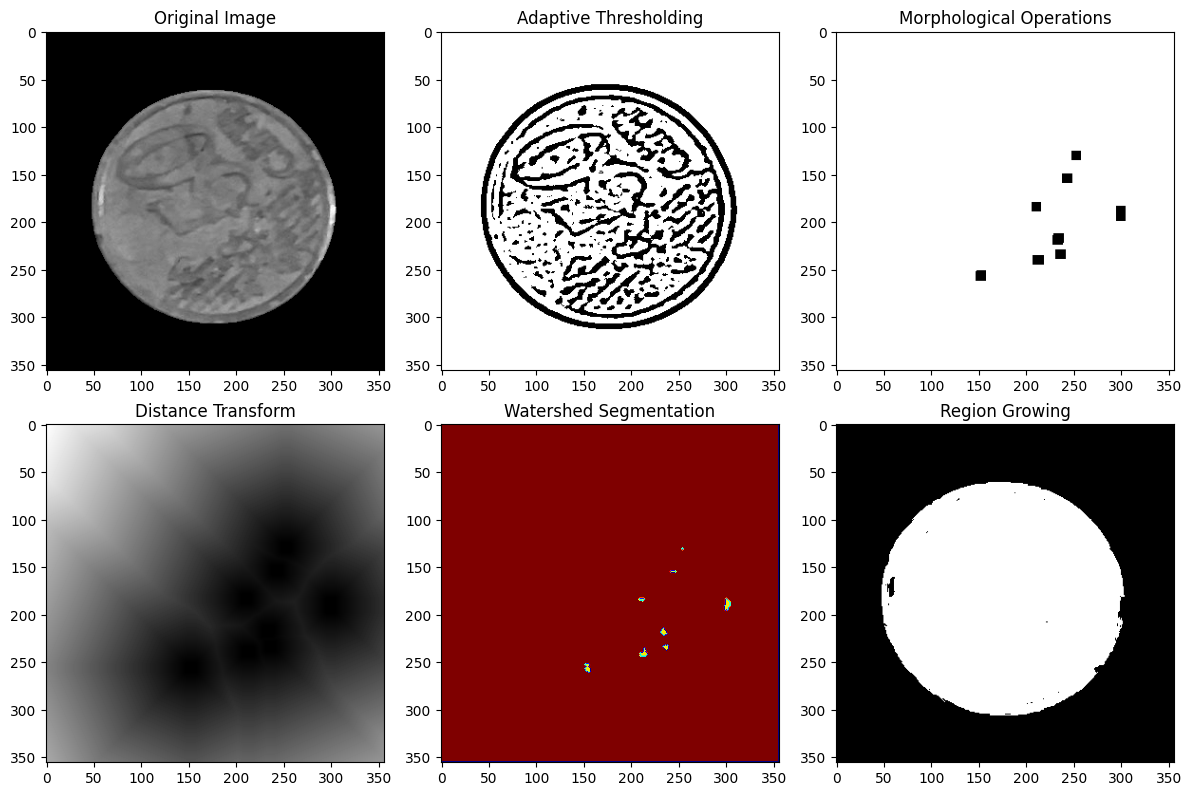

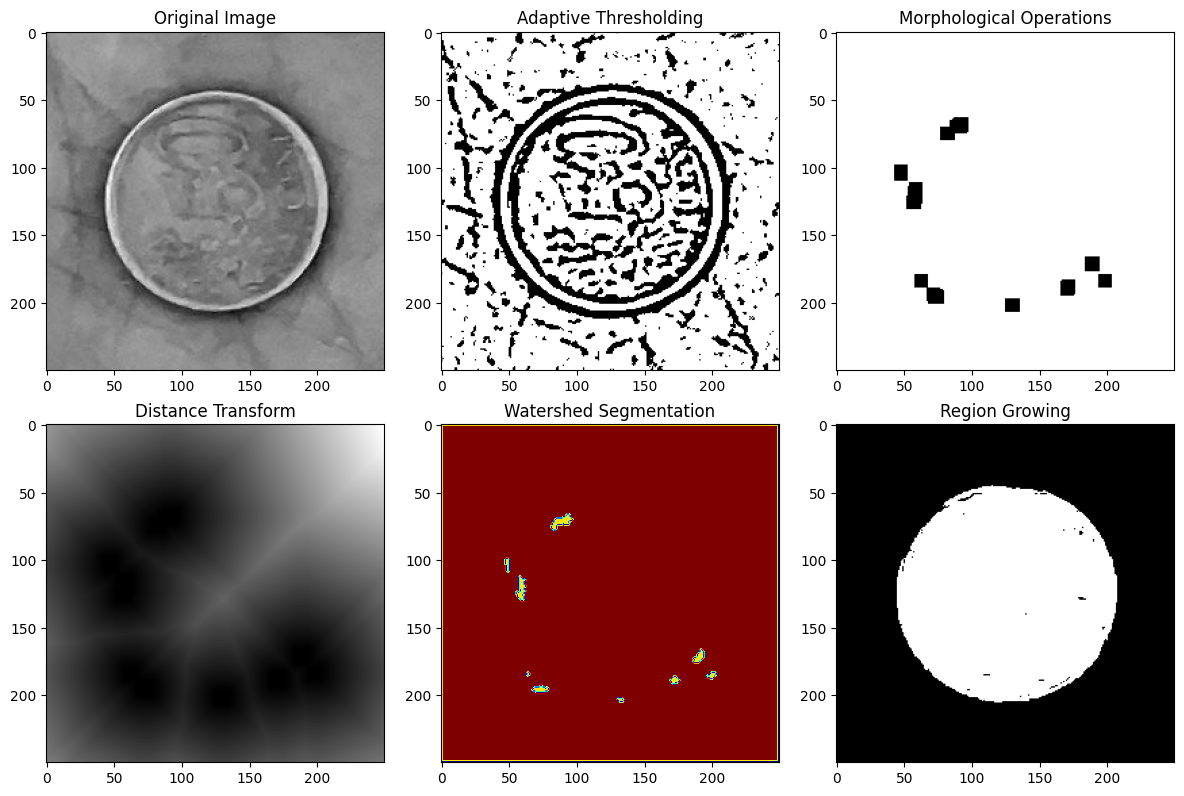

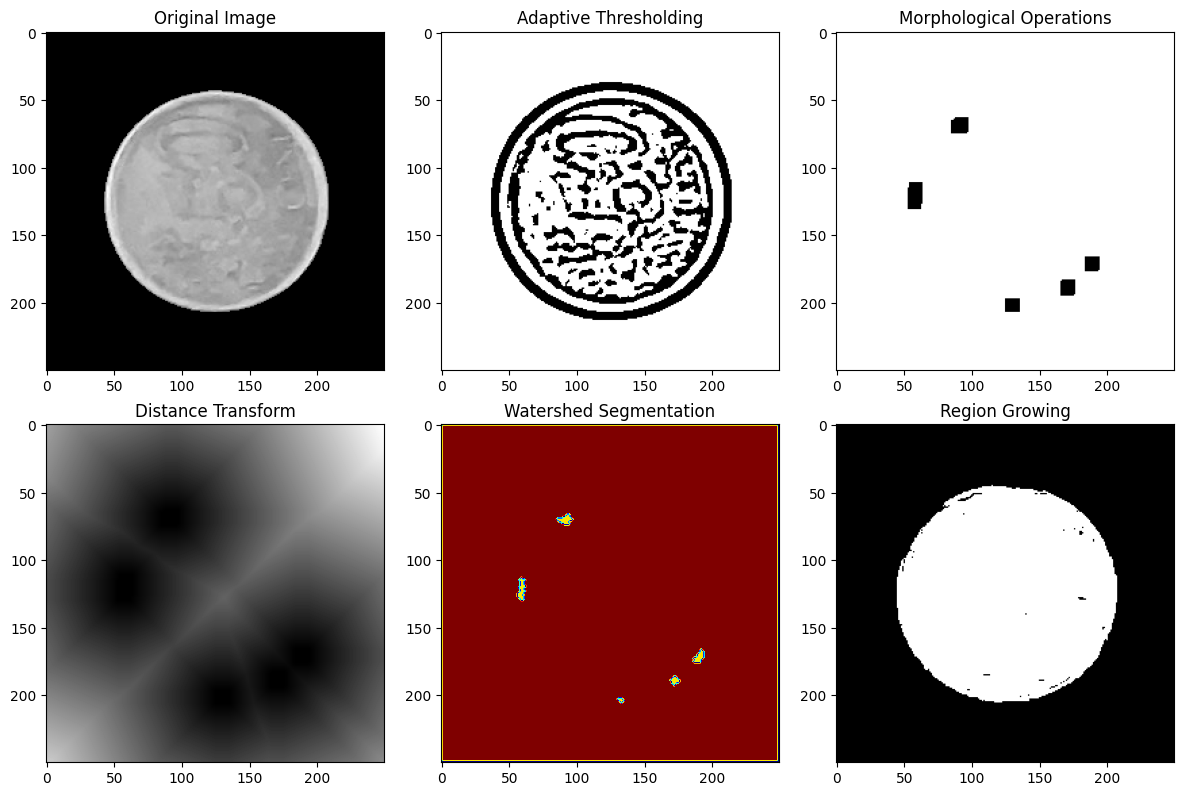

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Function for region growing
def region_grow(image, region, seed, threshold):
    # Initialize a queue
    queue = []

    # Add the seed to the queue
    queue.append(seed)

    # Get image dimensions
    height, width = image.shape

    while queue:
        # Get a point from the queue
        current_point = queue.pop()

        # Extract coordinates of the current point
        y, x = current_point

        # Check the 8 neighbors of the current point
        for i in range(-1, 2):
            for j in range(-1, 2):
                # Calculate coordinates of the neighbor
                neighbor_x = x + i
                neighbor_y = y + j

                # Check if the neighbor is inside the image
                if 0 <= neighbor_x < width and 0 <= neighbor_y < height:
                    # Calculate the intensity difference between the neighbor and the seed
                    intensity_diff = abs(int(image[neighbor_y, neighbor_x]) - int(image[y, x]))

                    # Check if the intensity difference is below the threshold and the region is not set
                    if intensity_diff < threshold and region[neighbor_y, neighbor_x] == 0:
                        # Add the neighbor to the region
                        region[neighbor_y, neighbor_x] = 255

                        # Add the neighbor to the queue for further exploration
                        queue.append((neighbor_y, neighbor_x))

# Define the name of the images you want to process
image_name = "coin.jpeg"

# Define the threshold for region growing
threshold = 7

# Define the seed point (adjust as needed)
seed_point = (100, 100)

# Define the root directory where images are located (including subdirectories)
root_dir = "/content/drive/MyDrive/public_coin"

# Find all images with the specified name in the directory tree
image_files = glob.glob(os.path.join(root_dir, "**", image_name), recursive=True)

# Process each image file
for image_file in image_files:
    # Load the image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded successfully
    if image is not None:
        # Convert to 8-bit format
        image = cv2.convertScaleAbs(image)

        # Apply Gaussian smoothing for denoising
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Create subplots for displaying images
        plt.figure(figsize=(12, 8))

        # Original Image
        plt.subplot(2, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')

        # Adaptive Thresholding
        th = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        plt.subplot(2, 3, 2)
        plt.imshow(th, cmap='gray')
        plt.title("Adaptive Thresholding")

        # Morphological operations
        kernel = np.ones((4, 4), np.uint8)
        BW1 = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
        BW2 = cv2.bitwise_not(cv2.morphologyEx(cv2.bitwise_not(BW1), cv2.MORPH_CLOSE, kernel, iterations=2))
        BW3 = cv2.erode(BW2, np.ones((4, 4), np.uint8), iterations=1)
        plt.subplot(2, 3, 3)
        plt.imshow(BW3, cmap='gray')
        plt.title('Morphological Operations')

        # Calculate the distance transform
        D = cv2.distanceTransform(BW3, cv2.DIST_L2, 3)
        plt.subplot(2, 3, 4)
        plt.imshow(D, cmap='gray')
        plt.title('Distance Transform')

        # Marker selection
        sure_bg = cv2.dilate(BW3, np.ones((4, 4), np.uint8), iterations=3)
        sure_fg = BW3
        unknown = cv2.subtract(sure_bg, sure_fg)

        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0

        # Watershed segmentation
        L = cv2.watershed(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), markers)
        num_labels = np.max(L)
        plt.subplot(2, 3, 5)
        plt.imshow(L, cmap='jet')
        plt.title('Watershed Segmentation')

        # Region Growing
        region_grown = np.zeros_like(image, dtype=np.uint8)
        region_grow(image, region_grown, seed_point, threshold=threshold)
        plt.subplot(2, 3, 6)
        plt.imshow(region_grown, cmap='gray')
        plt.title('Region Growing')

        plt.tight_layout()
        plt.show()

    else:
        print(f"Error loading the image: {image_file}")


The code chooses markers for the watershed segmentation by identifying definite background pixels, definite foreground pixels, and unknown pixels. These markers serve as initial points for the watershed algorithm.

**2. Comparing edge-based and region-based segmentation on the coin segmentation task**

In [ ]:
!pip install scikit-image

The histogram of grayscale values is calculated and displayed alongside the grayscale image to provide insights into the intensity distribution of each processed image. This analysis can be useful for understanding the characteristics of the coin images and may help guide subsequent image processing steps.

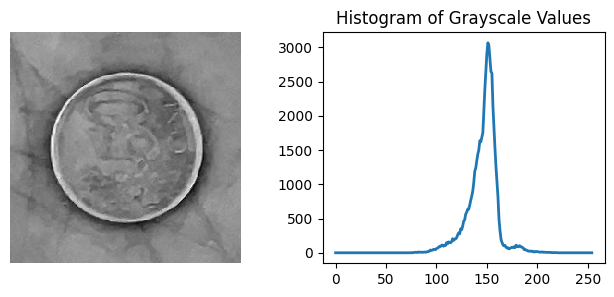

In [10]:
# Directory containing the grayscale images
image_dir = "/content/drive/MyDrive/public_coin/143088702989443443739693074959456317442/original"

# Get a list of image files in the directory
image_files = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpeg', '.jpg', '.png'))]

# Iterate over each image file in the directory
for image_file in image_files:
    # Load the image in grayscale
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Calculate the histogram of grayscale values
    hist = np.histogram(img, bins=np.arange(0, 256))

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    axes[0].axis('off')
    axes[1].plot(hist[1][:-1], hist[0], lw=2)
    axes[1].set_title('Histogram of Grayscale Values')
    plt.show()


A simple way to segment the coins is to choose a threshold based on the histogram of grey values. Unfortunately, thresholding this image gives a binary image that either misses significant parts of the coins or merges parts of the background with the coins:

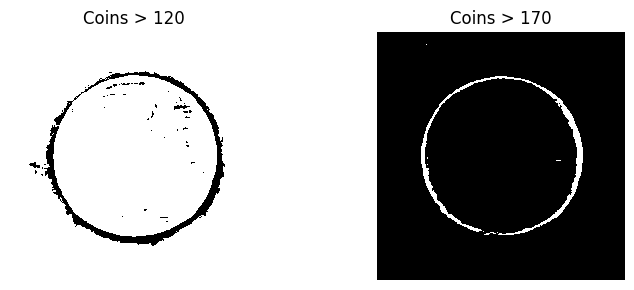

In [11]:
# Iterate over each image file in the directory
for image_file in image_files:
    # Load the image in grayscale
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Create two binary images with different thresholds
    binary_img_1 = (img > 120).astype(np.uint8) * 255
    binary_img_2 = (img > 170).astype(np.uint8) * 255

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

    # Visualize the first binary image
    axes[0].imshow(binary_img_1, cmap=plt.cm.gray, interpolation='nearest')
    axes[0].set_title('Coins > 120')

    # Visualize the second binary image
    axes[1].imshow(binary_img_2, cmap=plt.cm.gray, interpolation='nearest')
    axes[1].set_title('Coins > 170')

    # Configure subplot properties
    for a in axes:
        a.axis('off')

    # Adjust the layout of the figure
    plt.tight_layout()
    plt.show()

Coin images frequently contain noise or artifacts, which can obstruct precise segmentation. Canny's implemented Gaussian smoothing decreases noise, contributing to more resilient following edge detection.
* Coins exhibit well-defined borders that distinguish them from the backdrop. The Canny detector is proficient at detecting these sharp edges, providing clear contours of the coins.
* Canny enables the adjustment of threshold values to optimize edge detection for specific images, making it suitable for various coin images with varying lighting conditions and contrasts.
* Connected Components can then be processed to identify individual coins, which is crucial for coin segmentation.

Edge Preservation is also maintained. By distinguishing between strong and weak edges and connecting weak edges to strong ones, the Canny edge detector can maintain continuous boundaries, which are crucial to accurately outlining the shape of coins.

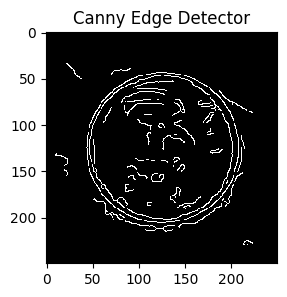

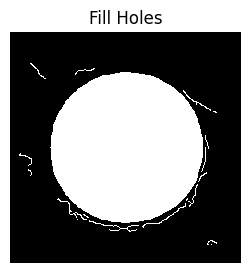

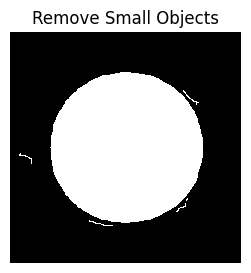

In [13]:
from skimage.feature import canny
from skimage import feature

# Apply the Canny edge detector
edges = feature.canny(img)

# Create a figure
fig, ax = plt.subplots(figsize=(4, 3))

# Display the edges detected using the Canny detector
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Canny Edge Detector')

# Show the figure
plt.show()

from scipy import ndimage as ndi

# Fill the holes in the binary image
fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Fill Holes')
ax.axis('off')

from skimage import morphology

# Remove small objects from the filled image
coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Remove Small Objects')
ax.axis('off')

plt.show()


**DATA AUGMENTATION**

Data augmentation is a potent method for increasing the quantity of data and preventing model overfitting.

[The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf).

Given our limited dataset, I plan to experiment with various augmentations, including horizontal flips, affine transforms, and perspective transforms.
These adjustments will enable us to expand our available dataset and enhance the accuracy of the next deep learning model.
I will also apply manipulations for brightness, contrast, and color, in addition to image blurring and sharpening.
Gaussian noise random crops have been already done. All these transformations can be easily implemented using Albumentations, a fast augmentation library.

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

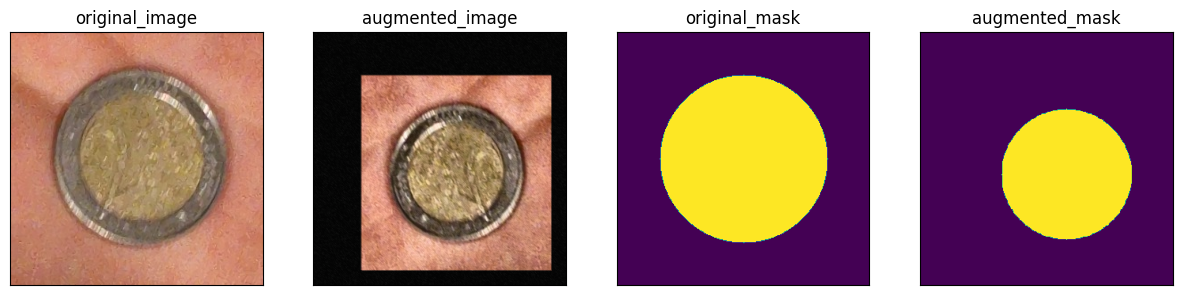

In [9]:
import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

# Define the visualize function
def visualize(**images):
    """Plot images and masks."""
    plt.figure(figsize=(15, 7))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, len(images), i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name)
        plt.imshow(image)
    plt.show()

# Load your image (coin.jpeg) and mask if available
image_path = "/content/drive/MyDrive/public_coin/102586421877817102033289037136558555138/original/coin.jpeg"
image = np.array(Image.open(image_path))
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)  # Initialize a black mask

# Create a white circular mask
h, w = mask.shape
center = (w // 2, h // 2)  # Center of the coin (you can adjust this)
radius = min(w, h) // 3  # Radius of the coin (you can adjust this)
cv2.circle(mask, center, radius, (255, 255, 255), thickness=cv2.FILLED)

# Overlay the mask on the original image to visualize it
masked_image = cv2.bitwise_and(image, image, mask=mask)
masked_image = Image.fromarray(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

# Display the original image and the masked image
masked_image.show()

# Ensure the image has 3 channels (RGB)
if image.shape[2] == 4:
    image = image[:, :, :3]

# Define the augmentation settings
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

# Apply the augmentation to both image and mask
augmentation = get_training_augmentation()
augmented = augmentation(image=image, mask=mask)

# Visualize the original and augmented images and masks
visualize(original_image=image, augmented_image=augmented['image'], original_mask=mask, augmented_mask=augmented['mask'])


This code section illustrates how to utilize spectral clustering with various approaches to partition images into regions based on similarities in gradient values, a handy tool for grouping comparable regions in images without prior knowledge of clusters. It's useful in case I have more money in the same image

Spectral clustering: kmeans, 0.91s
Spectral clustering: discretize, 0.81s
Spectral clustering: cluster_qr, 1.32s


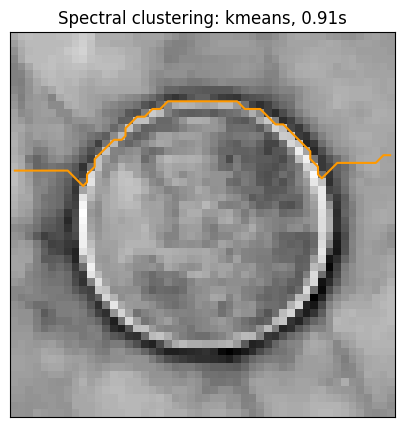

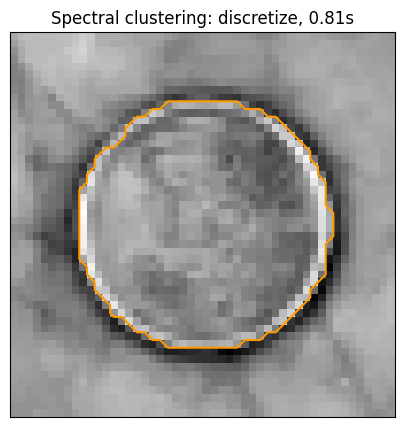

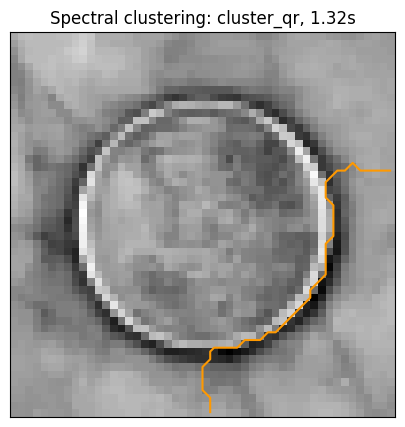

In [19]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale
from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

# Load and preprocess your own dataset
# Replace 'image_dir' with the directory containing your grayscale images
image_dir = "/content/drive/MyDrive/public_coin/143088702989443443739693074959456317442/original"

# List of image files in the directory
image_files = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpeg', '.jpg', '.png'))]

# Initialize an empty list to store processed images
processed_images = []

# Process each image in your dataset
for image_file in image_files:
    # Load the image in grayscale
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded successfully
    if img is not None:
        # Preprocess the image as needed (e.g., smoothing)

        # Append the processed image to the list
        processed_images.append(img)

# Convert the processed images to a numpy array
image_array = np.array(processed_images)
# Resize images and apply spectral clustering
n_regions = 1  # Specify the number of regions
n_regions_plus = 3

for img in image_array:
    # Resize the image to 20% of the original size
    smoothened_img = gaussian_filter(img, sigma=2)
    rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", anti_aliasing=False)

    # Convert the image into a graph with the value of the gradient on the edges
    graph = image.img_to_graph(rescaled_img)

    # Take a decreasing function of the gradient: an exponential
    beta = 10
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

    # Apply spectral clustering
    for assign_labels in ("kmeans", "discretize", "cluster_qr"):
        t0 = time.time()
        labels = spectral_clustering(
            graph,
            n_clusters=(n_regions + n_regions_plus),
            eigen_tol=1e-7,
            assign_labels=assign_labels,
            random_state=42,
        )
        t1 = time.time()
        labels = labels.reshape(rescaled_img.shape)

        # Display the segmented image
        plt.figure(figsize=(5, 5))
        plt.imshow(rescaled_img, cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
        title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
        print(title)
        plt.title(title)
        for l in range(n_regions):
            colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
            plt.contour(labels == l, colors=colors)

# Show the final visualization
plt.show()

**3. Neural Network**

Overall, this code trains a Convolutional Neural Network (CNN) to categorise images into two classes using your dataset. It loads and preprocesses the data, splits it for training and evaluation, and assesses the model's performance. It also permits the visualisation of training and validation metrics, such as accuracy and loss, using Matplotlib. I just provided the code for this part because the dataset must be modify properly to use it and i just did it for a small part of the entire dataset.

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6746 - accuracy: 0.7000 - val_loss: 0.7719 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 82ms/step - loss: 0.6304 - accuracy: 0.6000 - val_loss: 0.7915 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 73ms/step - loss: 0.5362 - accuracy: 0.7000 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 78ms/step - loss: 0.3979 - accuracy: 0.9000 - val_loss: 0.5507 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 79ms/step - loss: 0.3248 - accuracy: 1.0000 - val_loss: 0.3538 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 67ms/step - loss: 0.2156 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 82ms/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.1193 - val_accuracy: 1.0000
Epoch 8/20
1/1 [=====

IndexError: ignored

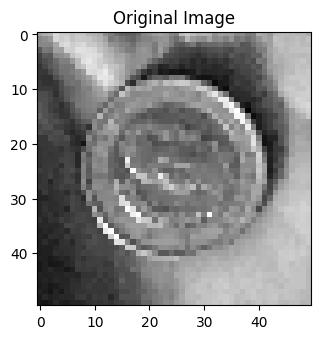

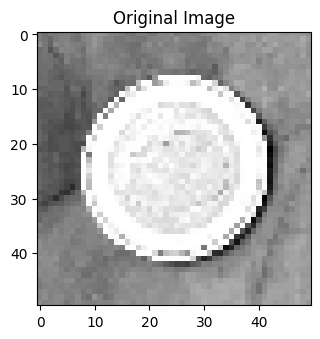

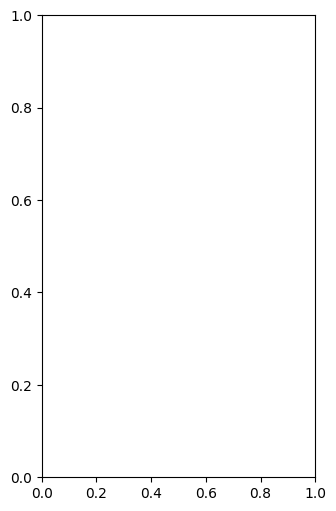

In [48]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the paths to your dataset
dataset_dir = "/content/drive/MyDrive/public_coin_data/"
class_0_dir = os.path.join(dataset_dir, "no_bg")
class_1_dir = os.path.join(dataset_dir, "original")

# Define a function to load and preprocess images from a directory
def load_and_preprocess_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith((".jpeg", ".png")):
            image = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = cv2.resize(image, (50, 50))
                image = image / 255.0  # Normalize pixel values
                images.append(image)
                labels.append(label)
    return images, labels

# Load and preprocess images from both classes
class_0_images, class_0_labels = load_and_preprocess_images(class_0_dir, label=0)
class_1_images, class_1_labels = load_and_preprocess_images(class_1_dir, label=1)

# Combine the data from both classes
images = np.array(class_0_images + class_1_images)
labels = np.array(class_0_labels + class_1_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# One-hot encode the target labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define and compile the CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", input_shape=(50, 50, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=1, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

# Evaluate the model
loss, mean_iou = model.evaluate(np.array(X_test), np.array(y_test))
print(f'Test Loss: {loss:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')

# Make predictions on test data
predictions = model.predict(np.array(X_test))

# Define a function to overlay the segmentation mask on the original image
def overlay_mask(image, mask, alpha=0.5):
    colored_mask = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    return cv2.addWeighted(image, alpha, colored_mask, 1 - alpha, 0)

# Visualize some results
for i in range(5):  # Display results for the first 5 test samples
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Original Image')


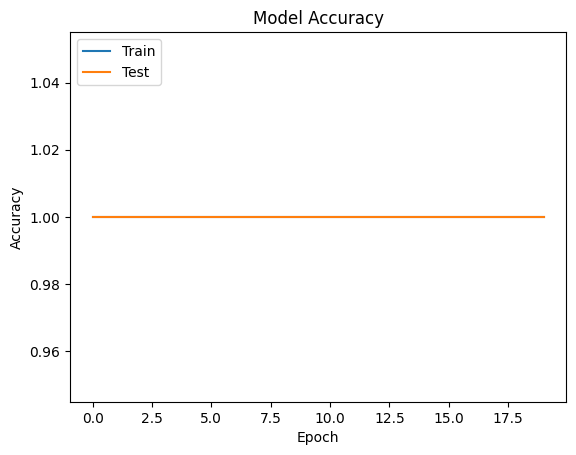

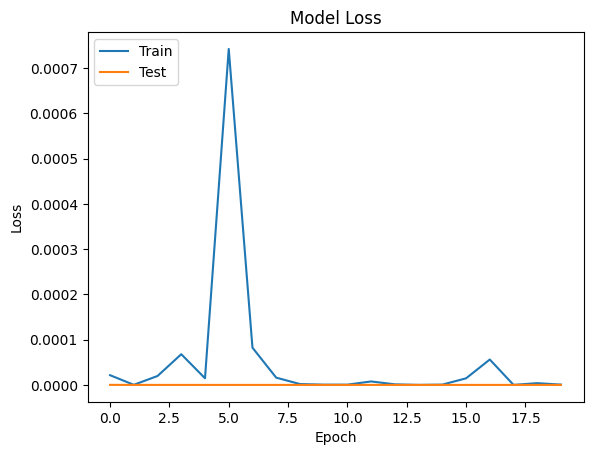

In [50]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
